# Progetto Tesi Calciatori Under 21

## Importazione librerie

In [1]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import time
from request_get import *
from datetime import datetime
from dateutil import relativedelta
import statsmodels.api as sm
from scipy.stats import f_oneway,kstest
from scipy import stats
import numpy as np
import ruptures as rpt
import pymannkendall as mk

## Importazione dataset

In [27]:
# le funzioni che seguono servono a prendere i dati da fbref e transfermarkt e salvarli in un file xlsx (definite nel file request_get.py)
#get_fbref()
#get_transfermarkt()

In [2]:
pd.read_excel('Ranking_Italy.xlsx',sheet_name="1992").head()

,RK,Unnamed: 1,Team,Total Points,Previous Points,+/-
0,1.0,Germany,Germany,57.0,0.0,57.0
1,2.0,Italy,Italy,57.0,0.0,57.0
2,3.0,Brazil,Brazil,56.0,0.0,56.0
3,4.0,Sweden,Sweden,56.0,0.0,56.0
4,5.0,England,England,55.0,0.0,55.0


In [3]:
#create a loop to iterate over the sheet_name from 1992 to 2022 and take the RK for the italy row for each year
# Path: ranking.ipynb
df = pd.DataFrame()
for i in range(1992, 2023):
    df_temp = pd.read_excel('Ranking_Italy.xlsx', sheet_name=str(i))
    mean= df_temp['Total Points'].mean()
    df_temp = df_temp[df_temp['Team'] == 'Italy']
    df_temp['Year'] = i
    df_temp['Points'] = df_temp['Total Points']/mean
    df = pd.concat([df, df_temp], ignore_index=True)
df = df[['Year', 'RK','Total Points','Points']]
df['Year'] = df['Year'].astype(int)
df['RK'] = df['RK'].astype(int)
df.head()


,Year,RK,Total Points,Points
0,1992,2,57.0,1.356497
1,1993,3,59.0,1.290464
2,1994,2,62.0,1.323655
3,1995,6,58.0,1.200828
4,1996,5,61.0,1.204581


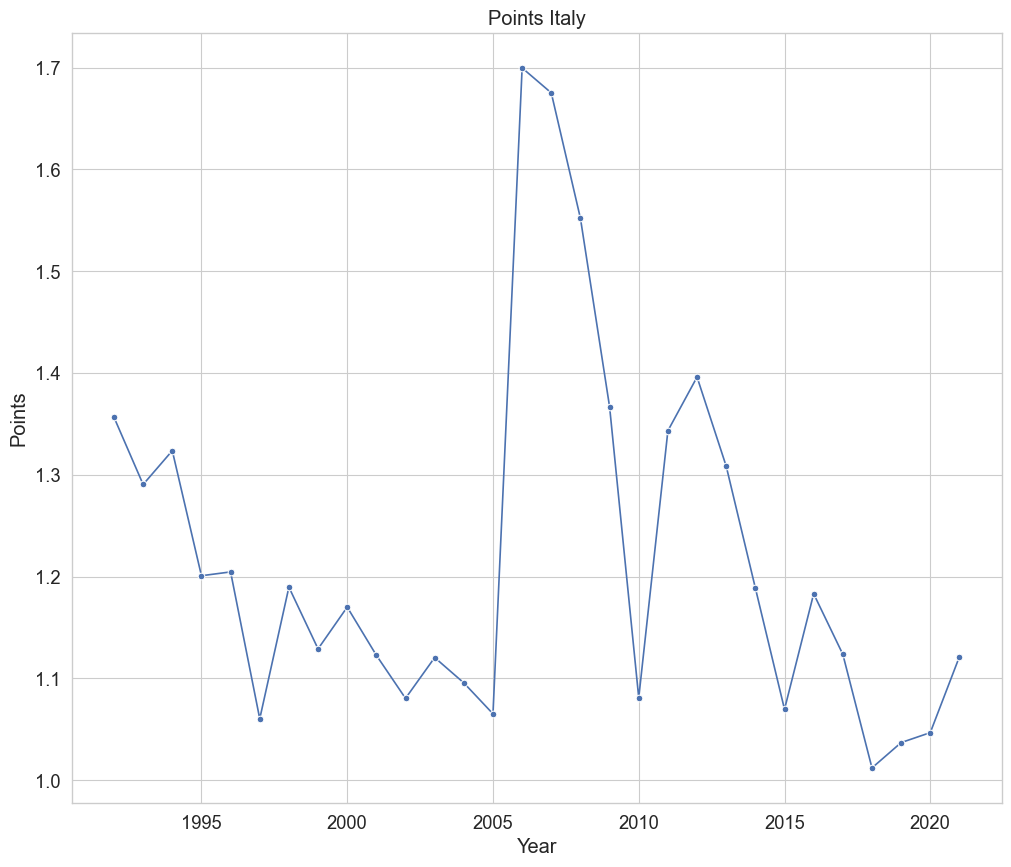

In [100]:
#show the position of Italy in the ranking over the years, invert the y label to have the first position on top
# Path: ranking.ipynb
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.lineplot(data=df, x="Year", y="Points", marker='o')
#make the ylabel jump by 3
plt.title('Points Italy')
plt.ylabel('Points')
plt.xlabel('Year')
plt.show()

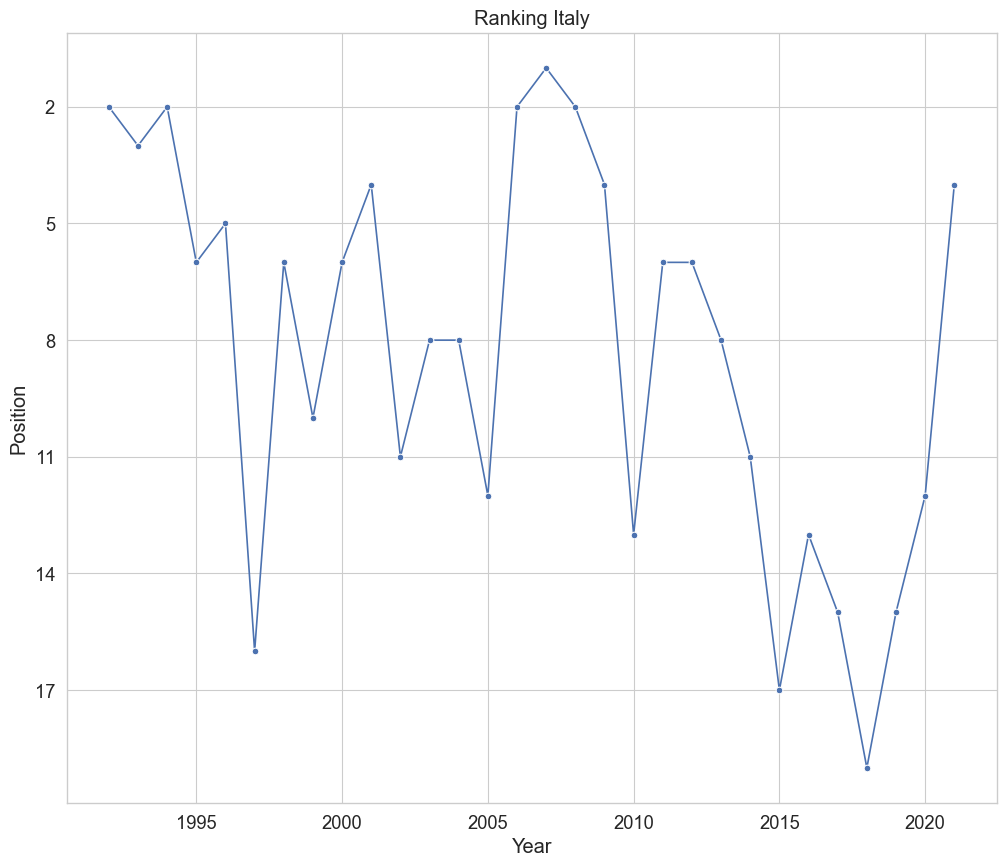

In [20]:
#show the position of Italy in the ranking over the years, invert the y label to have the first position on top
# Path: ranking.ipynb
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.lineplot(data=df, x="Year", y="RK", marker='o')
plt.gca().invert_yaxis()
#make the ylabel jump by 3
plt.yticks(np.arange(2, 20, 3))
plt.title('Ranking Italy')
plt.ylabel('Position')
plt.xlabel('Year')
plt.show()








In [4]:
italy_ranking=df[['Year','RK','Points']]
italy_ranking=italy_ranking.set_index('Year')
italy_ranking.index.name = None
italy_ranking.head()

,RK,Points
1992,2,1.356497
1993,3,1.290464
1994,2,1.323655
1995,6,1.200828
1996,5,1.204581


In [114]:
italy_ranking.tail()

,RK
2018,19
2019,15
2020,12
2021,4
2022,6


In [5]:
uefa_ranking=get_uefa_ranking()
uefa_ranking.head()

,Uefa_Ranking
1969,7.836865
1970,5.514087
1971,8.993416
1972,7.912378
1973,3.796904


## Estrazione minuti di gioco

In [6]:
# Calcola i minuti giocati dai giocatori under 21 per ogni anno, stabilendo come under 21 i giocatori nati dopo il 1 Agosto 
mesi = {
    "gen": 1, "feb": 2, "mar": 3, "apr": 4, "mag": 5, "giu": 6, "lug": 7, "ago": 8, "set": 9, "ott": 10, "nov": 11, "dic": 12
}
mins_played=pd.DataFrame(columns=["Minuti giocati under21","Minuti giocati Italiani","Minuti giocati Stranieri","Minuti giocati Oriundi"])
current_year = 2022

# Define the number of years you want to subtract
year_to_subtract = 54

for i in range(year_to_subtract):
    # Calculate the year to use in the URL
    year_url = f"{current_year - i}-{current_year + 1 - i}"
    
    
    #players_fbref=pd.read_excel(f"fbref\SerieA{year_url}-Under21.xlsx")
    players_tm=pd.read_excel(f"transfermarkt\SerieA{year_url}-Under21.xlsx")
    for j in range(len(players_tm)):
        parti = players_tm.loc[j,"Nato"].split('/')
        giorno_nasc = int(parti[0])
        mese_nasc = mesi[parti[1].lower()]  # Mappa il mese in minuscolo
        anno_nasc = int(parti[2])
        data_nasc = datetime(anno_nasc, mese_nasc, giorno_nasc)
        players_tm.loc[j,"Data di nascita"]=data_nasc
        data_inizio=datetime(current_year-i, 8, 1)
        anni=relativedelta.relativedelta(data_inizio, data_nasc).years
        players_tm.loc[j,"Anni"]=anni
    under=players_tm[players_tm["Anni"]<21]
    under_italia=under[under["Nazione"]=="Italia"]
    #under_stranieri = under[~under["Nazione"].str.contains(r'\bItalia\b', case=False, na=False)]
    under_stranieri= under[~under["Nazione"].str.contains(r'\b^Italia$\b|^Italia/\b', case=False, na=False)]
    under_oriundi = under[under["Nazione"].str.contains(r'^Italia/\b', case=False, na=False)]
    #under_stranieri=under[under["Nazione"]!="Italia"]
    mins_played.loc[year_url,"Minuti giocati Italiani"]=under_italia["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati under21"]=under["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Stranieri"]=under_stranieri["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Oriundi"]=under_oriundi["Minuti giocati"].sum()
    

    #mins_played.loc[year_url,"Minuti giocati FB"]=players_fbref["Minuti giocati"].sum()
    #mins_played.loc[year_url,"Minuti giocati TM"]=players_tm["Minuti giocati"].sum()
    #mins_played.loc[year_url,"TM - FB"]=mins_played.loc[year_url,"Minuti giocati FIX"]-mins_played.loc[year_url,"Minuti giocati FB"]




In [106]:
mins_played.head()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi
2022-2023,45572,18087,22674,4811
2021-2022,43062,13170,25820,4072
2020-2021,44079,11647,30255,2177
2019-2020,46677,18810,27093,774
2018-2019,58669,17383,39722,1564


### Normalizzazione minuti di gioco

In [7]:
#normalize Minuti giocati to total minutes played in the league and create another column(from 2022-2023 to 2004-2005 divided for 3420 minutes, from 2003-2004 to 1988-1989 divided for 3060 minutes and from 1987-1988 to 1968-1969 divided for 2700 minutes)
#mins_played["Minuti giocati normalizzati Fbref"]=0
#inverte l'ordine delle righe del dataframe con in testa 1968 e coda 2022
mins_played=mins_played.iloc[::-1]

"""mins_played["Minuti giocati normalizzati Italiani"]=0
mins_played["Minuti giocati normalizzati Stranieri"]=0
mins_played["Minuti giocati normalizzati under21"]=0
mins_played["Minuti giocati totali"]=0"""


#mins_played["Minuti giocati normalizzati Fbref"][0:19]=mins_played["Minuti giocati FBref"][0:19]/3420
#mins_played["Minuti giocati normalizzati Fbref"][19:35]=mins_played["Minuti giocati FBref"][19:35]/3060
#mins_played["Minuti giocati normalizzati Fbref"][35:]=mins_played["Minuti giocati FBref"][35:]/2700

mins_played[0:19]=mins_played[0:19]/(90*11*30*20)*100
mins_played[19:35]=mins_played[19:35]/(90*11*34*20)*100
mins_played[35:]=mins_played[35:]/(90*11*38*20)*100

"""mins_played["Minuti giocati normalizzati Italiani"][0:19]=mins_played["Minuti giocati Italiani"][0:19]/(90*11*30*20)*100
mins_played["Minuti giocati normalizzati Italiani"][19:35]=mins_played["Minuti giocati Italiani"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati Italiani"][35:]=mins_played["Minuti giocati Italiani"][35:]/(90*11*38*20)*100


mins_played["Minuti giocati normalizzati Stranieri"][0:19]=mins_played["Minuti giocati Stranieri"][0:19]/(90*11*30*20)*100
mins_played["Minuti giocati normalizzati Stranieri"][19:35]=mins_played["Minuti giocati Stranieri"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati Stranieri"][35:]=mins_played["Minuti giocati Stranieri"][35:]/(90*11*38*20)*100

mins_played["Minuti giocati normalizzati Oriundi"][0:19]=mins_played["Minuti giocati Oriundi"][0:19]/(90*11*30*20)*100
mins_played["Minuti giocati normalizzati Oriundi"][19:35]=mins_played["Minuti giocati Oriundi"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati Oriundi"][35:]=mins_played["Minuti giocati Oriundi"][35:]/(90*11*38*20)*100

mins_played["Minuti giocati normalizzati under21"][0:19]=mins_played["Minuti giocati under21"][0:19]/(90*11*30*20)*(100)
mins_played["Minuti giocati normalizzati under21"][19:35]=mins_played["Minuti giocati under21"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati under21"][35:]=mins_played["Minuti giocati under21"][35:]/(90*11*38*20)*100

mins_played["Minuti giocati totali"][0:19]=594000
mins_played["Minuti giocati totali"][19:35]=673200
mins_played["Minuti giocati totali"][35:]=752400

#convert ["Minuti giocati normalizzati FIX"] in float
mins_played["Minuti giocati normalizzati under21"]=mins_played["Minuti giocati normalizzati under21"].astype(float)
mins_played["Minuti giocati under21"]=mins_played["Minuti giocati under21"].astype(float)
mins_played["Minuti giocati normalizzati Italiani"]=mins_played["Minuti giocati normalizzati Italiani"].astype(float)"""
mins_played["Minuti giocati totali"]=0
mins_played["Minuti giocati totali"][0:19]=594000
mins_played["Minuti giocati totali"][19:35]=673200
mins_played["Minuti giocati totali"][35:]=752400

mins_played["Minuti giocati under21"]=mins_played["Minuti giocati under21"].astype(float)
mins_played["Minuti giocati Italiani"]=mins_played["Minuti giocati Italiani"].astype(float)
mins_played["Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"].astype(float)
mins_played["Minuti giocati Oriundi"]=mins_played["Minuti giocati Oriundi"].astype(float)


In [7]:
mins_played.tail()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi,Minuti giocati totali
2018-2019,7.797581,2.310340,5.279373,0.207868,752400
2019-2020,6.203748,2.500000,3.600877,0.102871,752400
2020-2021,5.858453,1.547980,4.021132,0.289341,752400
2021-2022,5.723285,1.750399,3.431685,0.541201,752400
2022-2023,6.056885,2.403907,3.013557,0.639421,752400


In [11]:
mins_played.tail()

,Minuti giocati FIX,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati normalizzati Italiani,Minuti giocati normalizzati Stranieri,Minuti giocati normalizzati FIX,Minuti giocati totali
2018-2019,58666.0,18945,39721,2.517943,5.27924,7.797182,752400
2019-2020,46669.0,19584,27085,2.602871,3.599814,6.202685,752400
2020-2021,44079.0,13824,30255,1.837321,4.021132,5.858453,752400
2021-2022,43060.0,17242,25818,2.291600,3.431419,5.723020,752400
2022-2023,45572.0,22898,22674,3.043328,3.013557,6.056885,752400


In [131]:
#modify the index of mins_played and get only the first part(examples: 2022-2023 becomes 2022, 2021-2022 becomes 2021)
mins_played.index=mins_played.index.str[:4].astype(int)

In [132]:
mins_played=mins_played.join(uefa_ranking,how='outer')
mins_played=mins_played.join(italy_ranking,how='outer')

In [133]:
mins_played.tail()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi,Minuti giocati totali,Uefa_Ranking,RK,Points
2018,7.797581,2.310340,5.279373,0.207868,752400,7.138945,19.0,1.012055
2019,6.203748,2.500000,3.600877,0.102871,752400,8.502446,15.0,1.036934
2020,5.858453,1.547980,4.021132,0.289341,752400,9.234215,12.0,1.046726
2021,5.723285,1.750399,3.431685,0.541201,752400,7.262794,4.0,1.121325
2022,6.056885,2.403907,3.013557,0.639421,752400,11.187226,6.0,1.099593


In [57]:
#convert the index of mins_played to DateTime
mins_played.index=pd.to_datetime(mins_played.index, format='%Y')

In [16]:
mins_played["Minuti giocati normalizzati FIX"].describe()

count    54.000000
mean      5.858159
std       1.345997
min       3.509804
25%       4.952726
50%       5.672116
75%       6.420986
max      10.101852
Name: Minuti giocati normalizzati FIX, dtype: float64

In [64]:
data_players[0:20].drop(["#","Unnamed: 1","country","ranking","teams"],axis=1).mean()

93/94    5.56115
94/95    6.06915
95/96    6.37535
96/97    6.31370
97/98    6.94290
dtype: float64

In [63]:
print(data_players.iloc[:,7][0:20].mean())
print(data_players["97/98"][0:20].mean())


6.942899999999999
4.009204081632653


# Correlazione minuti giocati Under 21 e Uefa Ranking

In [ ]:
#create a smoothed plot for the minutes played by under 21 players using the scipy.interpolate library and the splrep and splev functions
# Path: under21.ipynb


In [14]:
#usa la correlazione di Pearson per vedere se c'è una correlazione tra i minuti giocati e il ranking uefa
mins_played["Minuti giocati normalizzati FIX"].corr(mins_played["Uefa_Ranking"])


-0.3676344496469643

In [54]:
impressions = mins_played["Minuti giocati under21"][21:].values.reshape(-1, 1)


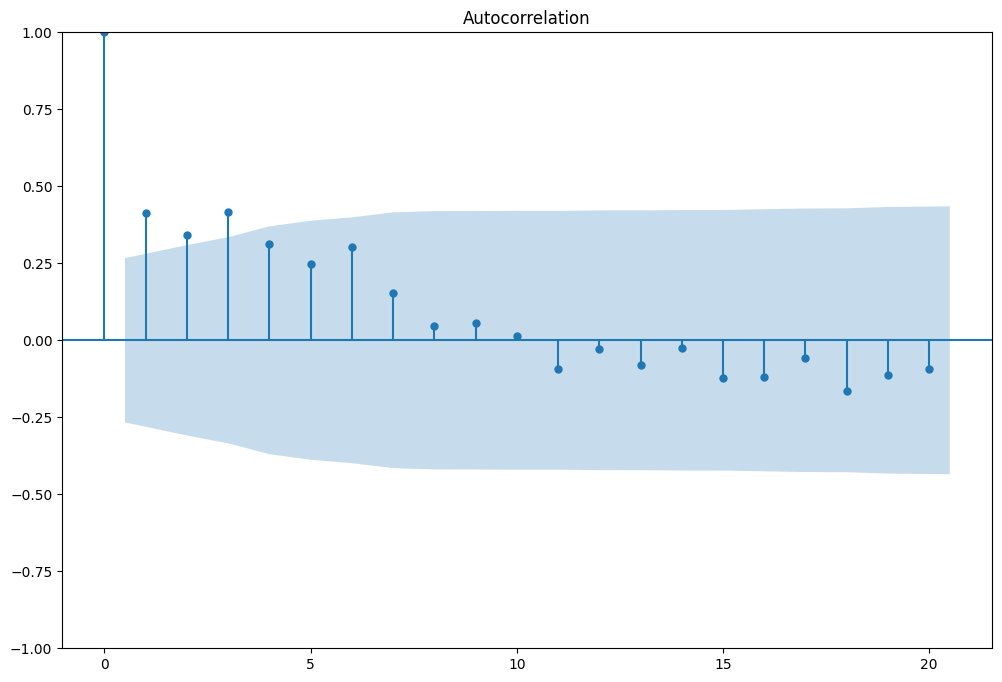

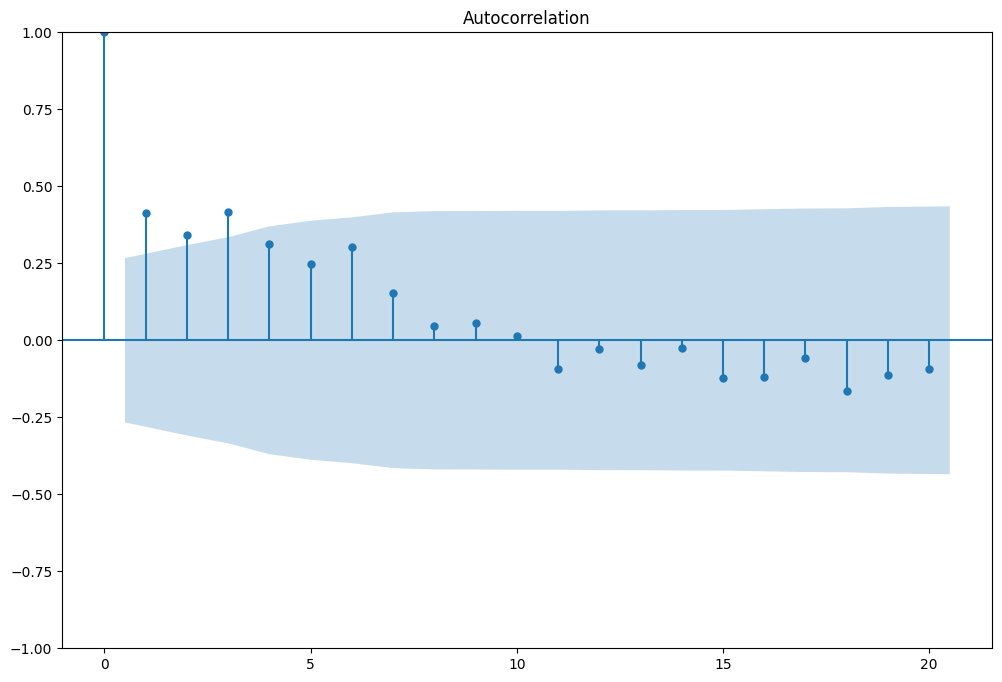

In [34]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(mins_played["Minuti giocati under21"], lags=20, ax=ax)

In [45]:
print(mk.original_test(mins_played["Minuti giocati under21"][11:26], alpha=0.05))
print(mk.hamed_rao_modification_test(mins_played["Minuti giocati under21"][39:], alpha=0.05))
print(mk.yue_wang_modification_test(mins_played["Minuti giocati under21"][39:], alpha=0.05))
print(mk.pre_whitening_modification_test(mins_played["Minuti giocati under21"][38:], alpha=0.05))

Mann_Kendall_Test(trend='decreasing', h=True, p=0.013347575926843103, z=-2.4743582965269675, Tau=-0.4857142857142857, s=-51.0, var_s=408.3333333333333, slope=-0.18695286195286198, intercept=6.926020003961181)
Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.011148850759557627, z=2.5379983577862397, Tau=0.3333333333333333, s=35.0, var_s=179.46309802302645, slope=0.14360108259629795, intercept=4.853245372384127)
Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=0.0010561084104812046, z=3.2751367397343807, Tau=0.3333333333333333, s=35.0, var_s=107.77026737889588, slope=0.14360108259629795, intercept=4.853245372384127)
Modified_Mann_Kendall_Test_PreWhitening_Approach(trend='increasing', h=True, p=0.04776124267510373, z=1.979486637221574, Tau=0.3904761904761905, s=41.0, var_s=408.3333333333333, slope=0.13155901116427432, intercept=4.80417663476874)


Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.035414895705223604, z=2.1035823408618612, Tau=0.2967032967032967, s=27.0, var_s=152.76633627019092, slope=0.14360108259629795, intercept=5.024261756319172)


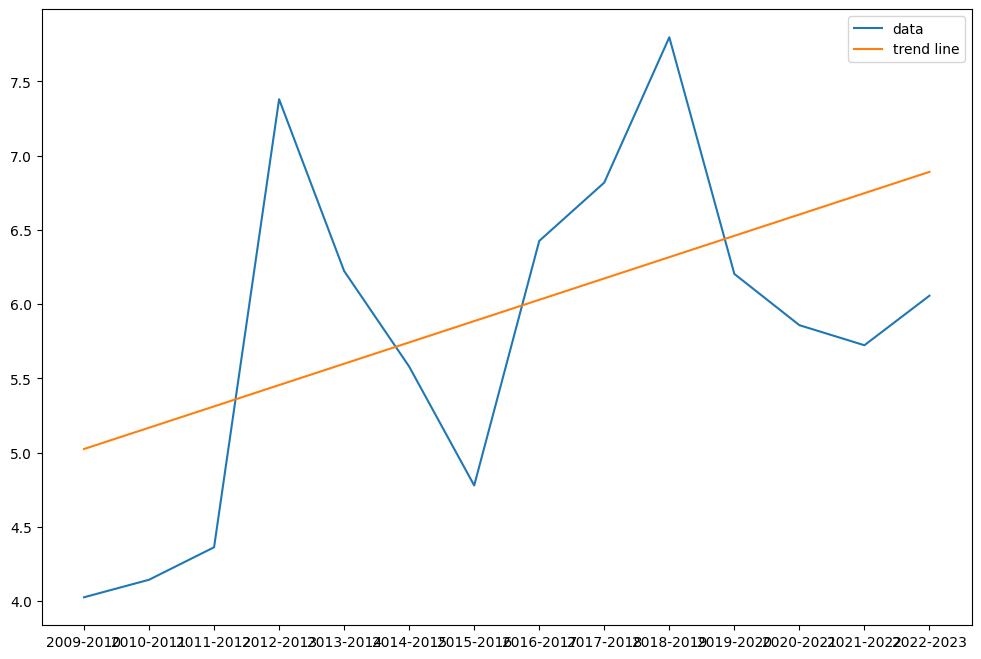

In [37]:
data = (mins_played["Minuti giocati under21"][40:])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.1005181732074647, z=1.6423467043540767, Tau=0.34065934065934067, s=31.0, var_s=333.6666666666667, slope=0.08801169590643268, intercept=1.9058612440191394)


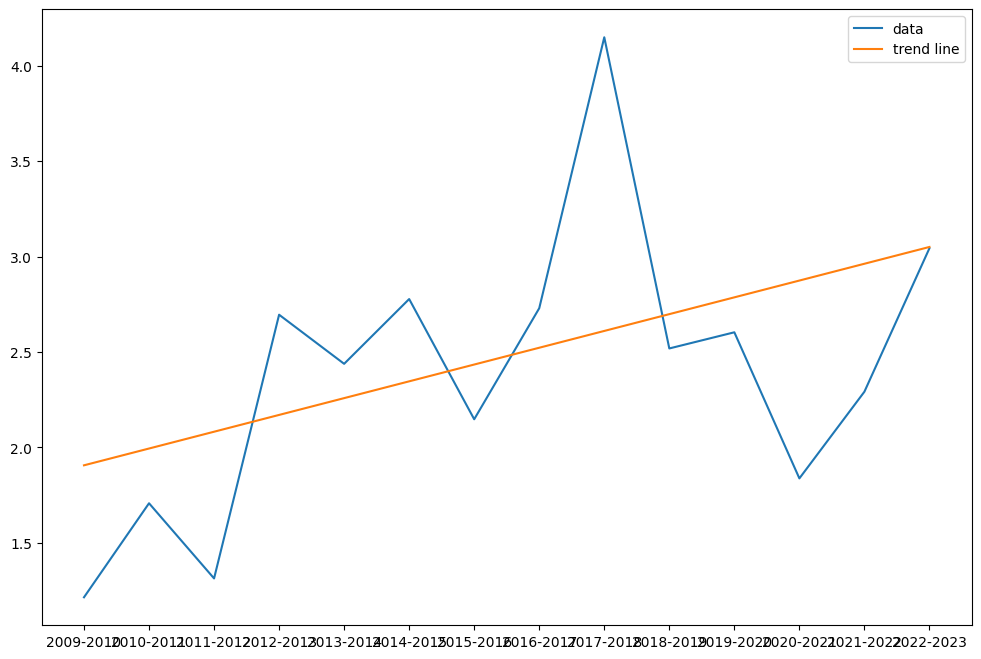

In [33]:
data = (mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

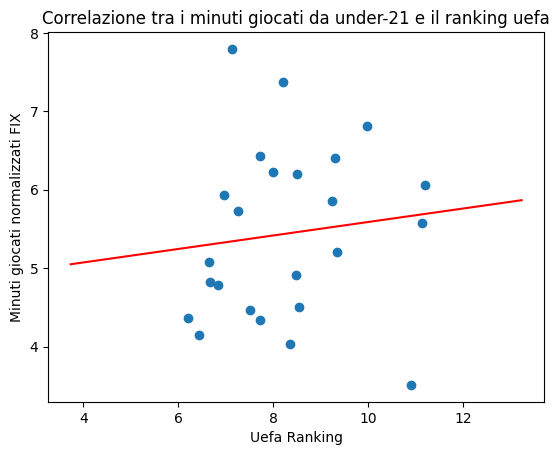

In [36]:
#crea un grafico a dispersione tra i minuti giocati e il ranking uefa
plt.scatter(mins_played["Uefa_Ranking"][30:],mins_played["Minuti giocati under21"][30:])
plt.xlabel("Uefa Ranking")
plt.ylabel("Minuti giocati normalizzati FIX")
plt.title("Correlazione tra i minuti giocati da under-21 e il ranking uefa")
#aggiungi la retta di regressione
plt.plot(np.unique(mins_played["Uefa_Ranking"]), np.poly1d(np.polyfit(mins_played["Uefa_Ranking"][30:], mins_played["Minuti giocati under21"][30:], 1))(np.unique(mins_played["Uefa_Ranking"])),color="red")

plt.show()


In [18]:
#fai unaregressione lineare tra i minuti giocati e il ranking uefa con statsmodels
X = mins_played["Uefa_Ranking"]
y = mins_played["Minuti giocati under21"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)


                                   OLS Regression Results                                  
Dep. Variable:     Minuti giocati normalizzati FIX   R-squared:                       0.141
Model:                                         OLS   Adj. R-squared:                  0.125
Method:                              Least Squares   F-statistic:                     8.538
Date:                             Tue, 07 Nov 2023   Prob (F-statistic):            0.00514
Time:                                     13:43:27   Log-Likelihood:                -88.059
No. Observations:                               54   AIC:                             180.1
Df Residuals:                                   52   BIC:                             184.1
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

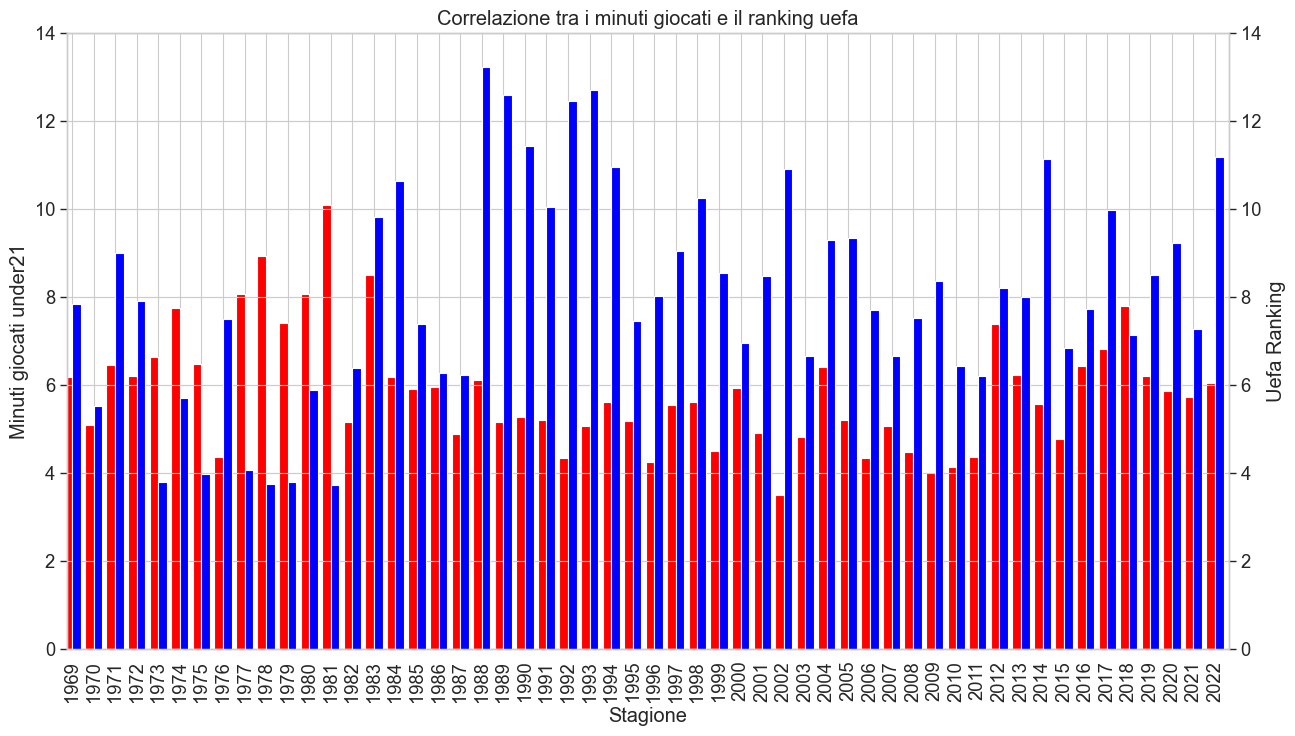

In [136]:
#crea un isotogramma con due barre una per i minuti giocati normalizzati e l'altra per il ranking uefa

fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()
mins_played["Minuti giocati under21"].plot(kind='bar',color='red', ax=ax, width=0.4, position=1)
mins_played["Uefa_Ranking"].plot(kind='bar',color='blue', ax=ax2, width=0.4, position=0)
ax.set_ylabel('Minuti giocati under21')
ax2.set_ylabel('Uefa Ranking')
ax.set_xlabel('Stagione')
ax.set_ylim(0, 14)
ax2.set_ylim(0, 14)
plt.title("Correlazione tra i minuti giocati e il ranking uefa")
plt.show()




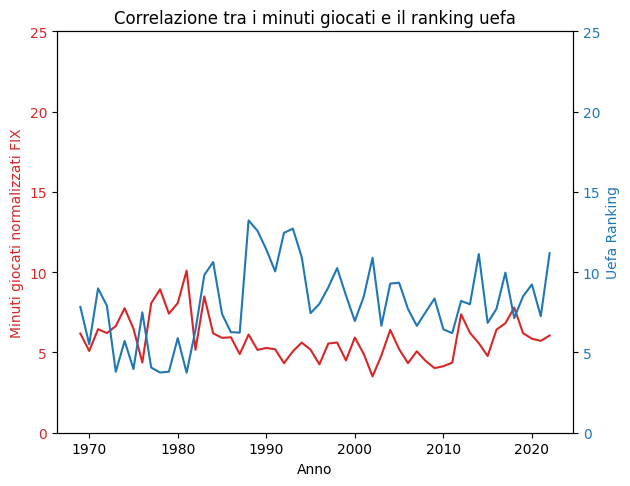

In [20]:
#plot two lines: one for the minutes played by under 21 players and one for the uefa ranking
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Anno')
ax1.set_ylabel('Minuti giocati normalizzati FIX', color=color)
ax1.plot(mins_played.index, mins_played["Minuti giocati normalizzati FIX"], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 25)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Uefa Ranking", color=color)  # we already handled the x-label with ax1
ax2.plot(mins_played.index, mins_played["Uefa_Ranking"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 25)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Correlazione tra i minuti giocati e il ranking uefa")
plt.show()


In [18]:
y

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.66329966e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.27272727e-02,
       6.98653199e-02, 3.36700337e-04, 7.19696970e-01, 4.35858586e-01,
       4.57912458e-01, 0.00000000e+00, 6.68350168e-02, 2.37373737e-01,
       1.30867499e-01, 1.48960190e+00, 5.97147950e-02, 4.07308378e-01,
       2.37670826e-01, 3.77748069e-01, 6.11259655e-01, 1.64587047e-01,
       1.31847891e+00, 2.98202614e+00, 2.27510398e+00, 1.86096257e+00,
       1.28267974e+00, 1.38680927e+00, 2.57590612e+00, 2.73152578e+00,
       1.84489633e+00, 1.74973418e+00, 1.98670920e+00, 2.57070707e+00,
       2.81127060e+00, 2.43660287e+00, 3.04930888e+00, 4.68540670e+00,
       3.78561935e+00, 2.80249867e+00, 2.63171186e+00, 3.69683679e+00,
       2.67025518e+00, 5.27937267e+00, 3.60087719e+00, 4.02113238e+00,
       3.43168527e+00, 3.01355662e+00])

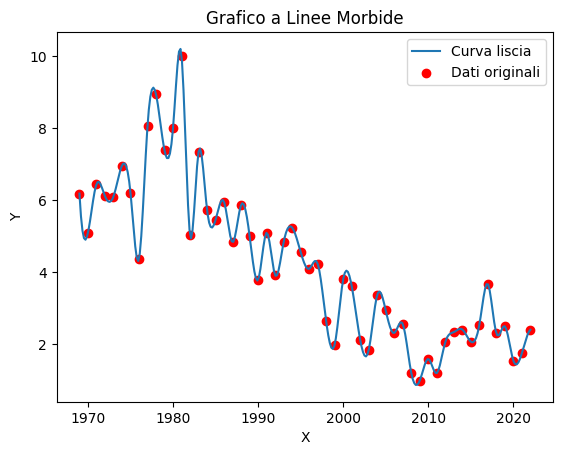

In [21]:
from scipy.interpolate import splrep, splev
x=mins_played.index
#convert x to a numpy array
x=np.array(x)
y=mins_played["Minuti giocati Italiani"]
#convert y to a numpy array
y=np.array(y)
x_smooth = np.linspace(x.min(), x.max(), 300)

# Calcola la curva di interpolazione
spl = splrep(x, y)
y_smooth = splev(x_smooth, spl)

# Crea il grafico
plt.plot(x_smooth, y_smooth, label='Curva liscia')
plt.scatter(x, y, color='red', label='Dati originali')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Grafico a Linee Morbide')
plt.show()


<Axes: >

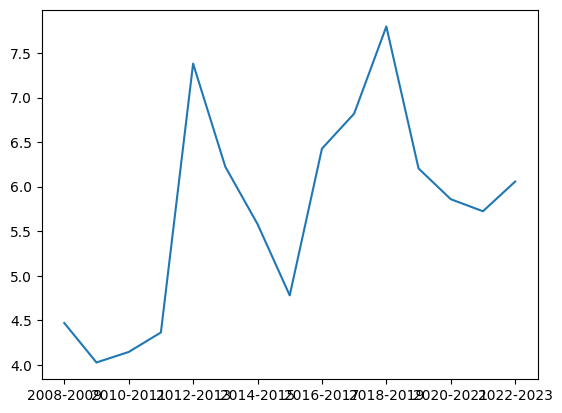

In [11]:
mins_played["Minuti giocati under21"][39:].plot()

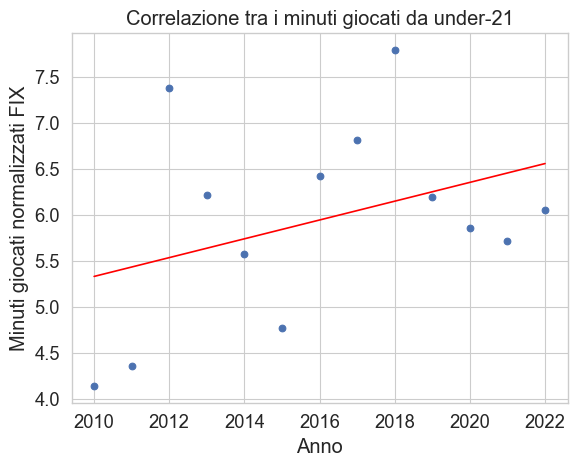

In [151]:
#stampa la retta di regressione per i minuti giocati da under 21
plt.scatter(mins_played.index[41:],mins_played["Minuti giocati under21"][41:])
plt.xlabel("Anno")
plt.ylabel("Minuti giocati normalizzati FIX")
plt.title("Correlazione tra i minuti giocati da under-21")
#aggiungi la retta di regressione
plt.plot(np.unique(mins_played.index[41:]), np.poly1d(np.polyfit(mins_played.index[41:], mins_played["Minuti giocati under21"][41:], 1))(np.unique(mins_played.index[41:])),color="red")






In [153]:
#fai la regressione linerare per i minuti giocati da under 21
X = mins_played.index[41:]
y = mins_played["Minuti giocati under21"][41:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)


                              OLS Regression Results                              
Dep. Variable:     Minuti giocati under21   R-squared:                       0.137
Model:                                OLS   Adj. R-squared:                  0.058
Method:                     Least Squares   F-statistic:                     1.739
Date:                    Thu, 23 Nov 2023   Prob (F-statistic):              0.214
Time:                            12:00:12   Log-Likelihood:                -17.947
No. Observations:                      13   AIC:                             39.89
Df Residuals:                          11   BIC:                             41.02
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


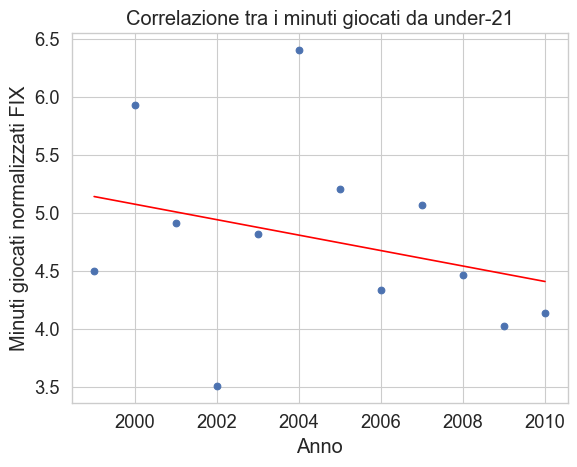

In [152]:
#stampa la retta di regressione per i minuti giocati da under 21
plt.scatter(mins_played.index[30:42],mins_played["Minuti giocati under21"][30:42])
plt.xlabel("Anno")
plt.ylabel("Minuti giocati normalizzati FIX")
plt.title("Correlazione tra i minuti giocati da under-21")
#aggiungi la retta di regressione
plt.plot(np.unique(mins_played.index[30:42]), np.poly1d(np.polyfit(mins_played.index[30:42], mins_played["Minuti giocati under21"][30:42], 1))(np.unique(mins_played.index[30:42])),color="red")

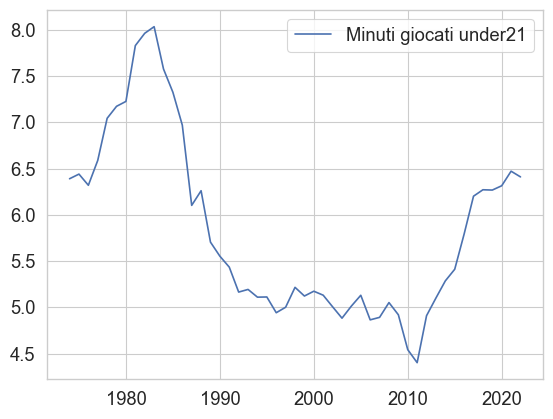

In [87]:

mins_played["Minuti giocati under21"].rolling(6).mean().plot()


plt.legend()

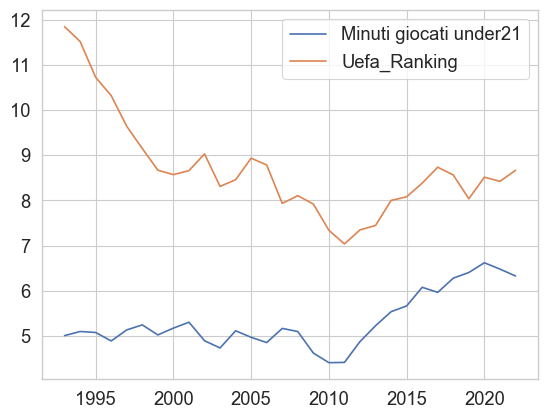

In [143]:
#fai la media di ogni tre anni per i minuti giocati da giocatori italiani e per i giocatori stranieri, poi creaci due lineplot

(mins_played["Minuti giocati under21"][20:]).rolling(5).mean().plot()
mins_played["Uefa_Ranking"][20:].rolling(5).mean().plot()
plt.legend()



(0.0, 12.0)

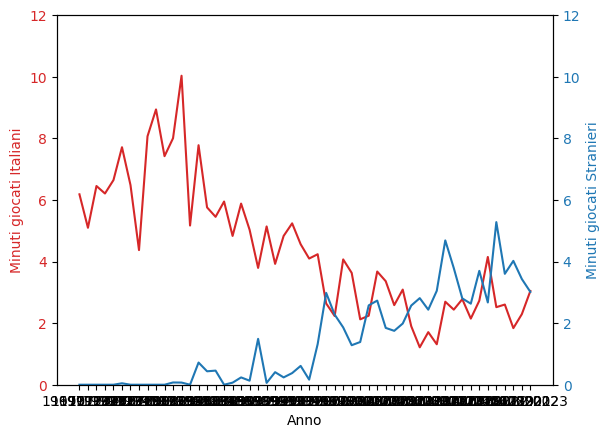

In [14]:
#create the same plot as before but with the lines smoothed
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Anno')
ax1.set_ylabel('Minuti giocati Italiani', color=color)
ax1.plot(mins_played.index, mins_played["Minuti giocati Italiani"] + mins_played["Minuti giocati Oriundi"], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 12)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Minuti giocati Stranieri", color=color)  # we already handled the x-label with ax1
ax2.plot(mins_played.index, mins_played["Minuti giocati Stranieri"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 12)



# Bayesian changepoint detection con Ruptures

In [72]:
mins_played["Minuti giocati normalizzati FIX"].index.year.values

array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [70]:
#create a 2 shape array with index and values of mins_played
impressions = mins_played["Minuti giocati under21"].values.reshape(-1, 1)
index = mins_played["Minuti giocati under21"].index.year.values.reshape(-1, 1)
impressions.shape, index.shape

#create a 2 shape array with index and impressions





((54, 1), (54, 1))

Punti di rottura trovati: [5, 15, 45, 54]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

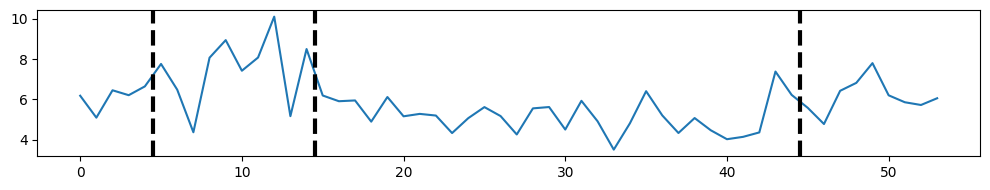

In [14]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l1"

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", result)

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions,[], result)

Punti di rottura trovati: [5, 15, 20, 45, 54]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

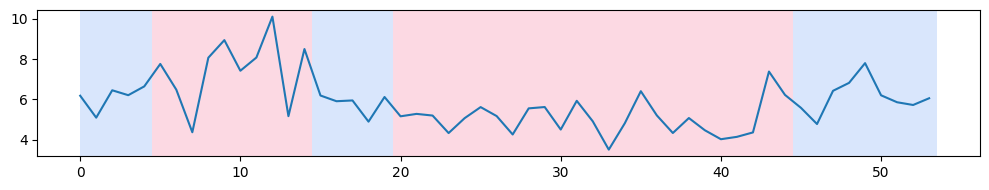

In [75]:
algo = rpt.Binseg(model="l1",min_size=3)
algo.fit(impressions)
result = algo.predict(n_bkps=4)
print("Punti di rottura trovati:", result)
# show results
rpt.display(impressions, result)


Punti di rottura trovati: [15, 25, 35, 45]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

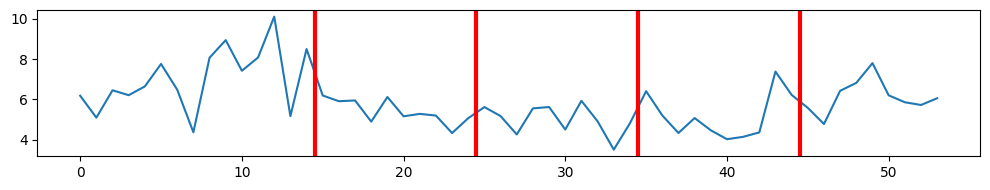

In [70]:
import ruptures as rpt

algo = rpt.Window(model="rbf",width=5, min_size=3)
algo.fit(impressions)
result = algo.predict(n_bkps=5)
print("Punti di rottura trovati:", result[0:-1])
rpt.display(impressions, [], result,computed_chg_pts_color="red",computed_chg_pts_linestyle="-")
#set the x ticks to be the index of mins_played


Punti di rottura trovati: [22]


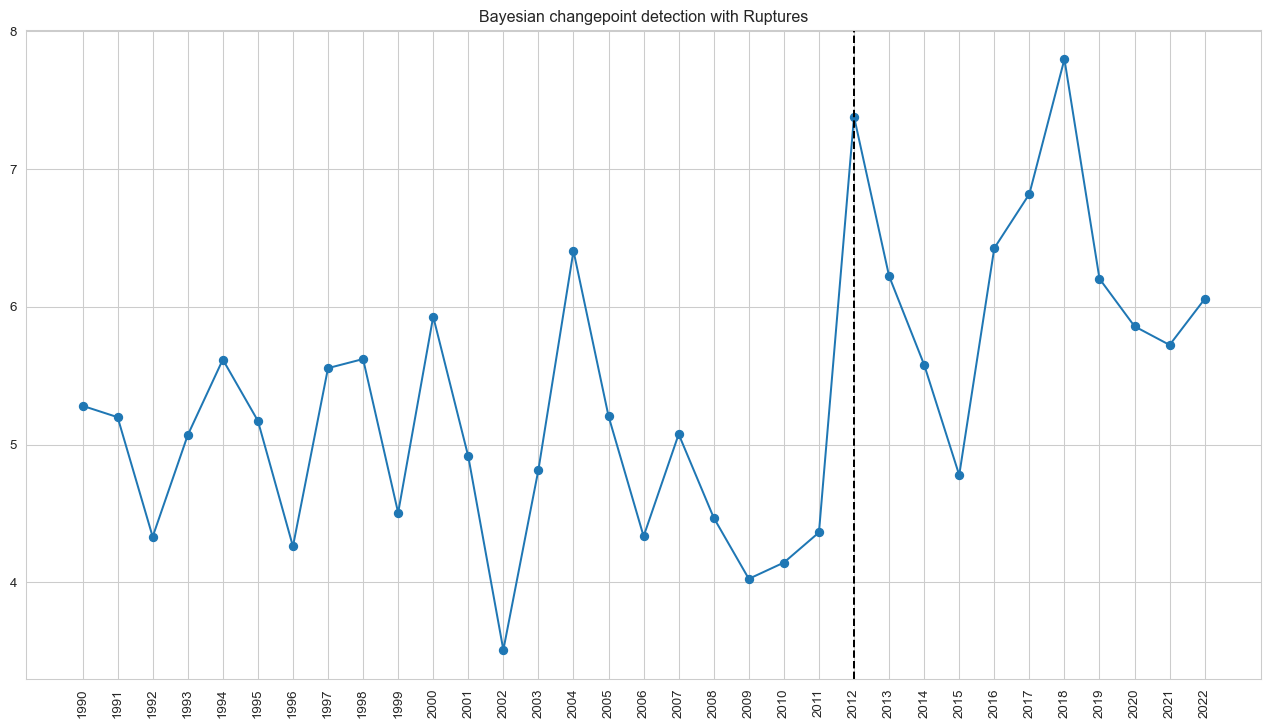

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(1280/96, 720/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=1)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='k', linestyle='--')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,33))
b=list(range(1990,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()



Punti di rottura trovati: [8, 15, 21, 37, 43]
Punti di rottura trovati: [8, 15, 21, 37, 43]
Punti di rottura trovati: [8, 15, 21, 37, 43]
Punti di rottura trovati: [8, 15, 21, 37, 43]
Punti di rottura trovati: [8, 15, 21, 37, 43]
Punti di rottura trovati: [7, 15, 21, 37, 43]
Punti di rottura trovati: [7, 15, 21, 37, 43]
Punti di rottura trovati: [7, 15, 21, 37, 43]
Punti di rottura trovati: [7, 15, 21, 37, 43]
Punti di rottura trovati: [7, 15, 21, 37, 43]
Punti di rottura trovati: [6, 12, 18, 24, 30]
Punti di rottura trovati: [6, 12, 18, 24, 30]
Punti di rottura trovati: [6, 12, 18, 24, 30]
Punti di rottura trovati: [6, 12, 18, 24, 30]
Punti di rottura trovati: [6, 12, 18, 24, 30]


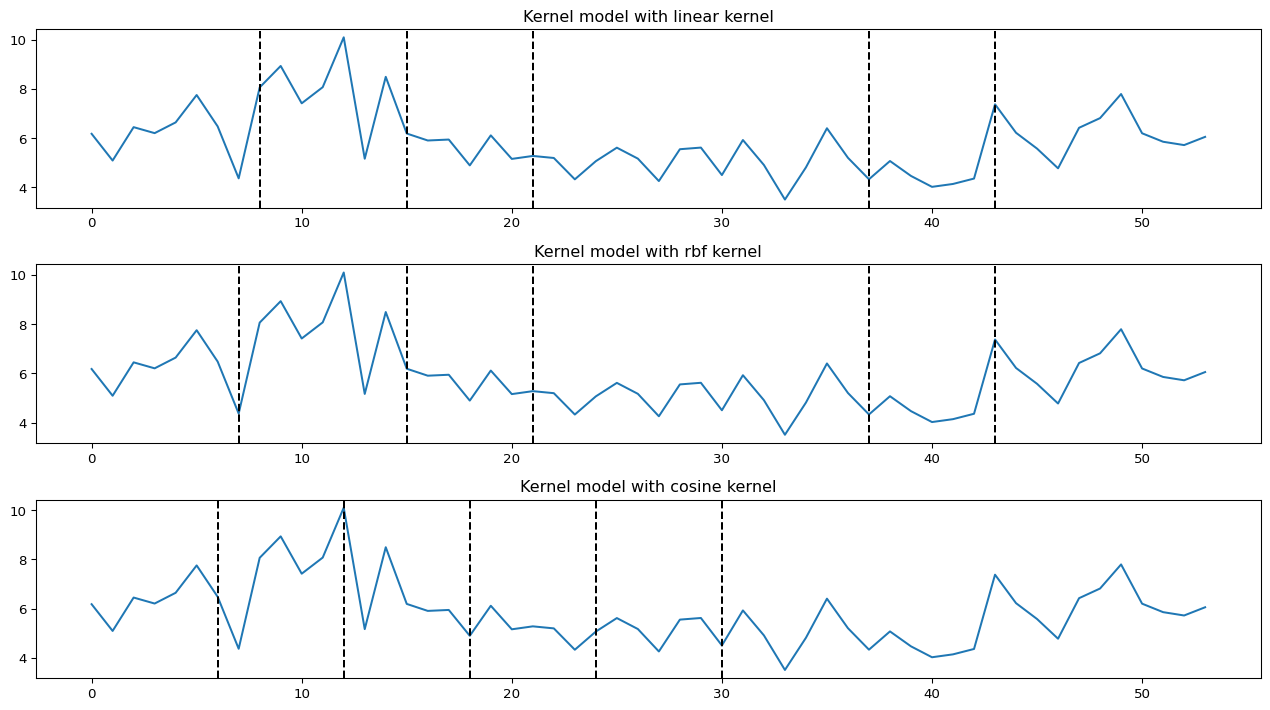

In [37]:
fig, ax = plt.subplots(3,1, figsize=(1280/96, 720/96), dpi=96)

for i, kernel in enumerate(['linear', 'rbf', 'cosine']):
    algo = rpt.KernelCPD(kernel=kernel, min_size=6)
    algo.fit(impressions)
    result = algo.predict(n_bkps=5)
    ax[i].plot(impressions)
    for bkp in result[0:-1]:
        ax[i].axvline(x=bkp, color='k', linestyle='--')
        print("Punti di rottura trovati:", result[0:-1])
    ax[i].set_title(f"Kernel model with {kernel} kernel")
#change the x ticks labels to be the index of mins_played

fig.tight_layout()

# Test Statistici

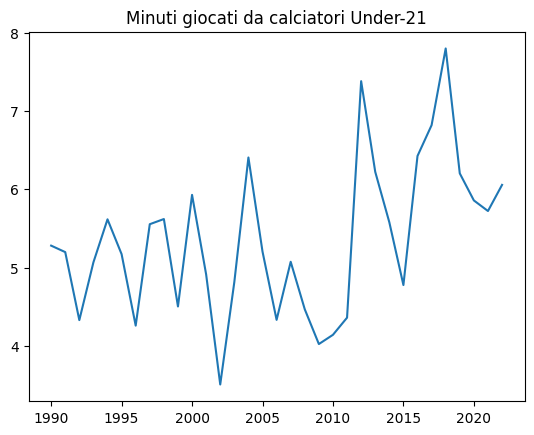

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

                                 SARIMAX Results                                  
Dep. Variable:     Minuti giocati under21   No. Observations:                   33
Model:                     ARIMA(1, 1, 1)   Log Likelihood                 -42.854
Date:                    Tue, 21 Nov 2023   AIC                             91.709
Time:                            16:35:15   BIC                             96.106
Sample:                                 0   HQIC                            93.166
                                     - 33                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3020      0.426      0.709      0.478      -0.533       1.137
ma.L1         -0.8613      0.230     -3.747      0.000      -1.312      -0.411
sigma2         0.830

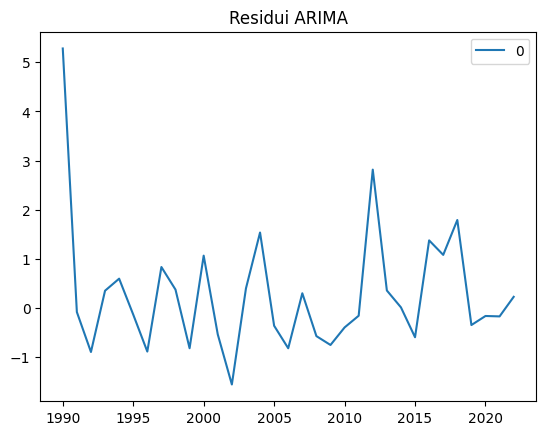

In [41]:
from statsmodels.tsa.arima.model import ARIMA
# Visualizza il grafico delle serie temporali
mins_played["Minuti giocati under21"][21:].plot()
plt.title('Minuti giocati da calciatori Under-21')
plt.show()

# Esegui l'analisi ARIMA
model = ARIMA(mins_played["Minuti giocati under21"][21:], order=(1, 1, 1))  # Ordine p, d, q
results = model.fit()

# Stampa il riassunto dell'analisi ARIMA
print(results.summary())

# Visualizza il grafico dei residui
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.title('Residui ARIMA')
plt.show()

In [6]:

# Esegui il test di Kolmogorov-Smirnov per verificare se i dati seguono una distribuzione normale
# Sostituisci 'minuti_giocati' con il nome della colonna dei minuti giocati nel tuo DataFrame
ks_statistic, ks_p_value = kstest(mins_played['Minuti giocati under21'], mins_played['Minuti giocati totali'])

# Valuta il risultato del test
alpha = 0.05  # Livello di significatività
if ks_p_value < alpha:
    print("I dati NON seguono una distribuzione normale.")
else:
    print("I dati seguono una distribuzione normale.")

# Stampare la statistica KS e il valore p per ulteriori riferimenti
print("Statistica KS:", ks_statistic)
print("Valore p:", ks_p_value)

I dati NON seguono una distribuzione normale.
Statistica KS: 1.0
Valore p: 8.04576932703266e-32


In [11]:
#copia l'index di mins_played in un'altra colonna chiamta anno
mins_played["Anno"]=mins_played.index
#rename "Minuti giocati under21" con "Minuti_giocati"
mins_played.rename(columns={"Minuti giocati under21":"Minuti_giocati"},inplace=True)
mins_played.head()

,Minuti_giocati,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi,Minuti giocati totali,Anno
1969-1970,6.181818,6.181818,0.0,0.000000,594000,1969-1970
1970-1971,5.095118,5.095118,0.0,0.000000,594000,1970-1971
1971-1972,6.451515,6.443939,0.0,0.007576,594000,1971-1972
1972-1973,6.208418,6.110943,0.0,0.097475,594000,1972-1973
1973-1974,6.644781,6.101178,0.0,0.543603,594000,1973-1974


In [85]:
# Aggiungi una colonna con gli anni numerici per l'analisi di regressione
mins_played_bis=mins_played[21:]
mins_played_bis['Anno_Numerico'] = mins_played_bis.index.year


# Esegui l'analisi di regressione
X = mins_played_bis[['Anno_Numerico',"Uefa_Ranking"]]
X = sm.add_constant(X)  # Aggiungi una costante (intercetta) al modello
y = mins_played_bis['Minuti giocati under21']

model = sm.OLS(y, X).fit()

# Stampa il risultato dell'analisi
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Minuti giocati under21   R-squared:                       0.210
Model:                                OLS   Adj. R-squared:                  0.157
Method:                     Least Squares   F-statistic:                     3.980
Date:                    Wed, 08 Nov 2023   Prob (F-statistic):             0.0293
Time:                            17:06:08   Log-Likelihood:                -41.835
No. Observations:                      33   AIC:                             89.67
Df Residuals:                          30   BIC:                             94.16
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

In [144]:
 # applica il test Mann-Whitney ai dati dal 2000 al 2011 e dal 2012 al 2022
from scipy.stats import wilcoxon
# Crea due campioni di dati


# Esegui il test di Mann-Whitney
stat, p = wilcoxon(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])
print('stat=%.3f, p=%.3f' % (stat, p))



stat=2.000, p=0.003


In [160]:
#mins_played["Minuti giocati under21"][31:42]
mins_played["Minuti giocati under21"][43:]

2012    7.380383
2013    6.223285
2014    5.579612
2015    4.778841
2016    6.425837
2017    6.818979
2018    7.797581
2019    6.203748
2020    5.858453
2021    5.723285
2022    6.056885
Name: Minuti giocati under21, dtype: float64

In [161]:
#Test di Mann-Kendall per Tendenze
from scipy.stats import mstats
# Crea due campioni di dati
# Esegui il test di Mann-Kendall
stat, p = mstats.kendalltau(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])
print('stat=%.3f, p=%.3f' % (stat, p))


stat=0.455, p=0.060


In [53]:
#fai il test t student per vedere se la variazione dei minuti giocati è significativa prima del 2012 e dopo il 2012
# Path: under21.ipynb
from scipy.stats import ttest_ind


# Esegui il test t
ttest_ind(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])



Ttest_indResult(statistic=-4.046468831328841, pvalue=0.0006310842777070342)

In [33]:
# Esegui l'ANOVA
f_statistic, p_value = stats.f_oneway(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])

# Stampa i risultati
print("Statistiche ANOVA:")
print("F-statistic:", f_statistic)
print("P-value:", p_value)
# Confronta il p-value con il livello di significatività (solitamente 0.05)
alpha = 0.05
if p_value < alpha:
    print("Il p-value è inferiore a", alpha, " - ci sono variazioni statisticamente significative.")
else:
    print("Il p-value è maggiore di", alpha, " - non ci sono variazioni statisticamente significative.")

Statistiche ANOVA:
F-statistic: 11.57748809866386
P-value: 0.002681823460552317
Il p-value è inferiore a 0.05  - ci sono variazioni statisticamente significative.


In [23]:
dati = np.array([46532, 43779, 45514, 49195, 61861, 51621])

# Specifica la distribuzione teorica o la distribuzione di riferimento
# Ad esempio, se stai cercando di confrontare con una distribuzione normale, puoi usare:
# distribuzione_di_riferimento = 'norm'

# Esegui il test Kolmogorov-Smirnov
kstest(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][42:])

KstestResult(statistic=0.6515151515151515, pvalue=0.00929088410579863, statistic_location=5.206007442849548, statistic_sign=1)

In [42]:
stats.kstest(mins_played['Minuti giocati under21'],mins_played['Uefa_ranking'] )

KeyError: 'Uefa_ranking'


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 23
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 year = 12 months = 365 days
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend     

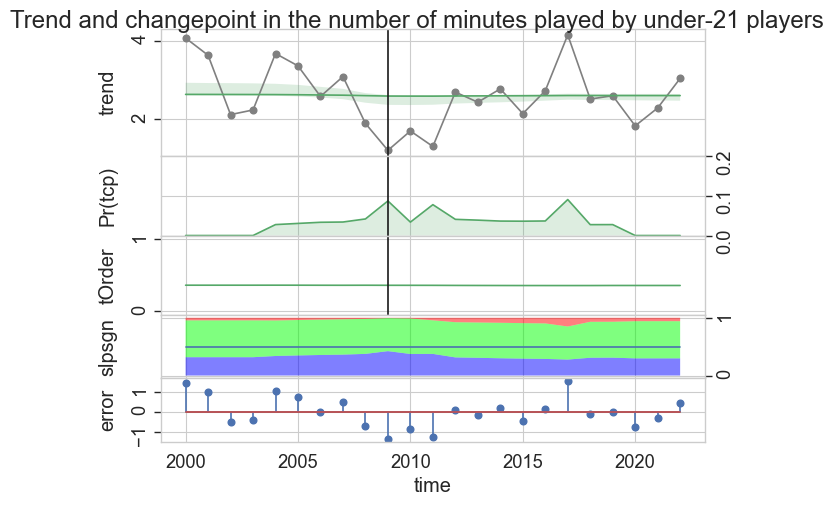

In [73]:
import Rbeast as rb
import numpy as np
o=rb.beast((mins_played['Minuti giocati Italiani'][31:]+mins_played['Minuti giocati Oriundi'][31:]), start=2000, deltat=1,period="1.0 year")
rb.plot(o,title='Trend and changepoint in the number of minutes played by under-21 players')
rb.print(o)


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 33
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 year = 12 months = 365 days
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend     

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


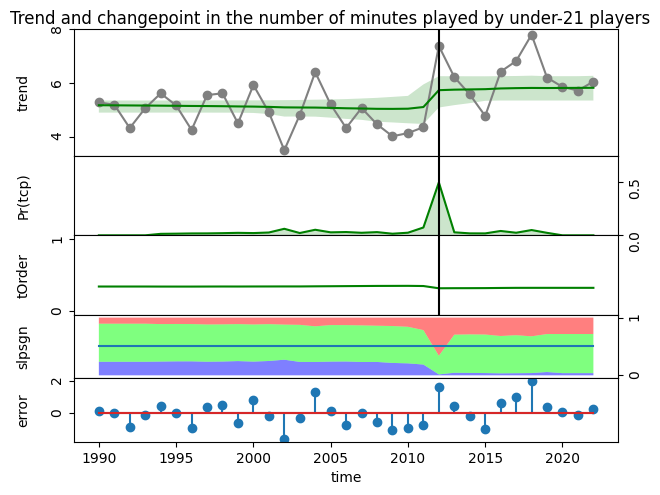

In [32]:
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'][21:], start=1990, deltat=1,period="1.0 year")
rb.plot(o,title='Trend and changepoint in the number of minutes played by under-21 players')
rb.print(o)

In [49]:
print(mins_played['Minuti giocati under21'][31:43].mean())
print(mins_played['Minuti giocati under21'][43:].mean())

4.7660773107754535
6.258808177468464


In [52]:
print((mins_played['Minuti giocati Italiani'][31:43]+mins_played['Minuti giocati Oriundi'][31:43]).mean())
print((mins_played['Minuti giocati Italiani'][43:]+mins_played['Minuti giocati Oriundi'][43:]).mean())

2.5754845930929524
2.6570852061282686



INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 28
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 year = 12 months = 365 days
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend     

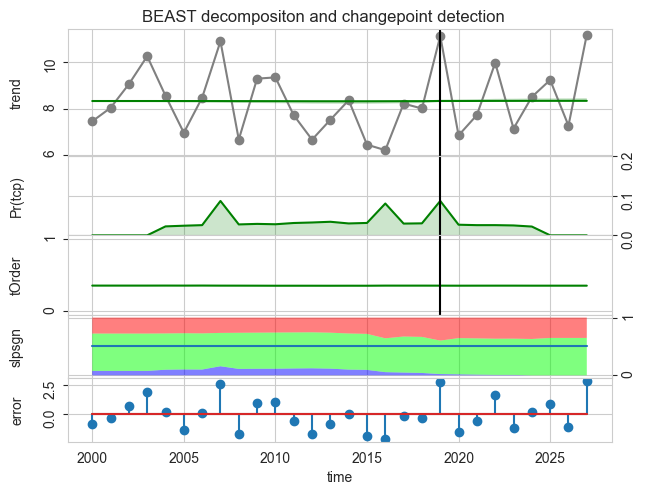

In [44]:
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played["Uefa_Ranking"][26:], start=2000, deltat=1,period="1.0 year")
rb.plot(o)
rb.print(o)

# Bayesian changepoint detection con Rbeast


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 54
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 year = 12 months = 365 days
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend     

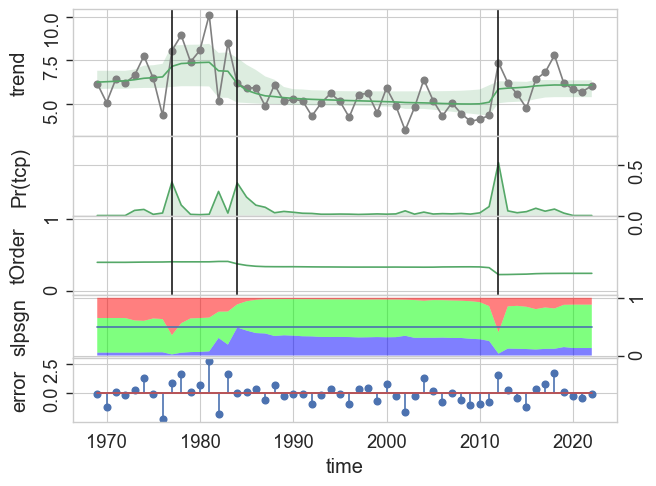

In [89]:
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'], start=1969, deltat=1,period="1.0 year")
rb.plot(o,title='')
rb.print(o)

# Grafici

In [78]:
#esegue la media dei minuti giocati normalizzati ogni 8 stagioni
mins_played_10=pd.DataFrame(columns=["Minuti giocati normalizzati TM"])
mins_played_10.loc["1969-1976","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][48:].mean()

mins_played_10.loc["1969-1976","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][48:].mean()


mins_played_10.head(8)

,Minuti giocati normalizzati TM,Minuti giocati normalizzati FIX
1969-1976,6.403704,6.149032
1977-1984,8.055366,7.807534
1985-1992,6.037921,5.355817
1993-2000,5.629846,5.216522
2001-2008,5.319778,4.841484
2009-2017,5.561553,5.365032
2017-2022,6.612219,6.409534


Text(0.5, 1.0, 'Minuti giocati dai giocatori Under 21 in Serie A ogni 8 anni')

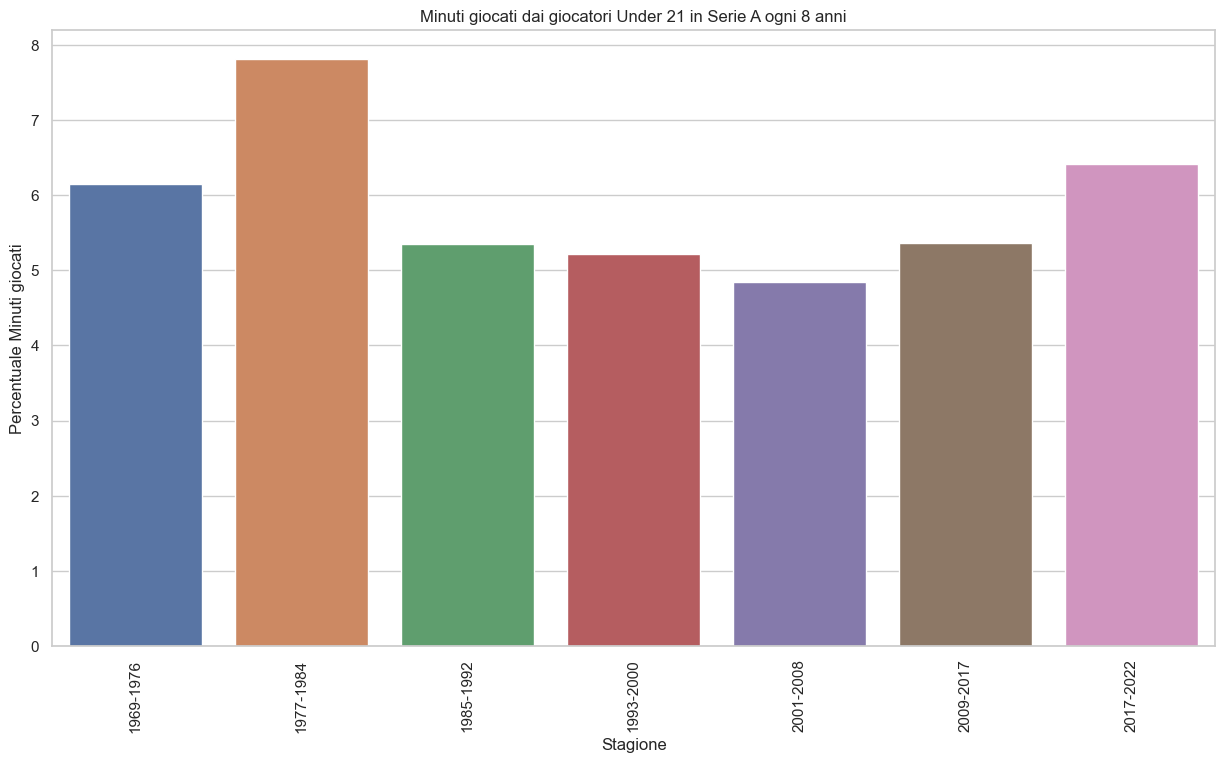

In [10]:
plt.figure(figsize=(15,8))
sns.barplot(x=mins_played_10.index, y=mins_played_10["Minuti giocati normalizzati FIX"])
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A ogni 8 anni")

C:\Users\franc\AppData\Local\Temp\ipykernel_19852\1339171240.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mins_played["Minuti giocati normalizzati FIX"], shade=True, color='blue', label='Minuti giocati')


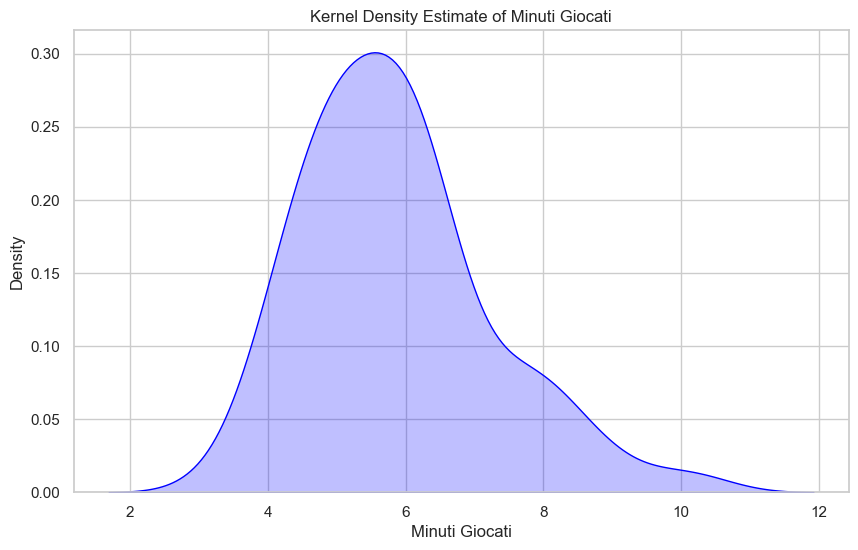

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(mins_played["Minuti giocati normalizzati FIX"], shade=True, color='blue', label='Minuti giocati')

# Customize the plot
plt.title('Kernel Density Estimate of Minuti Giocati')
plt.xlabel('Minuti Giocati')
plt.ylabel('Density')

# Show the plot
plt.show()


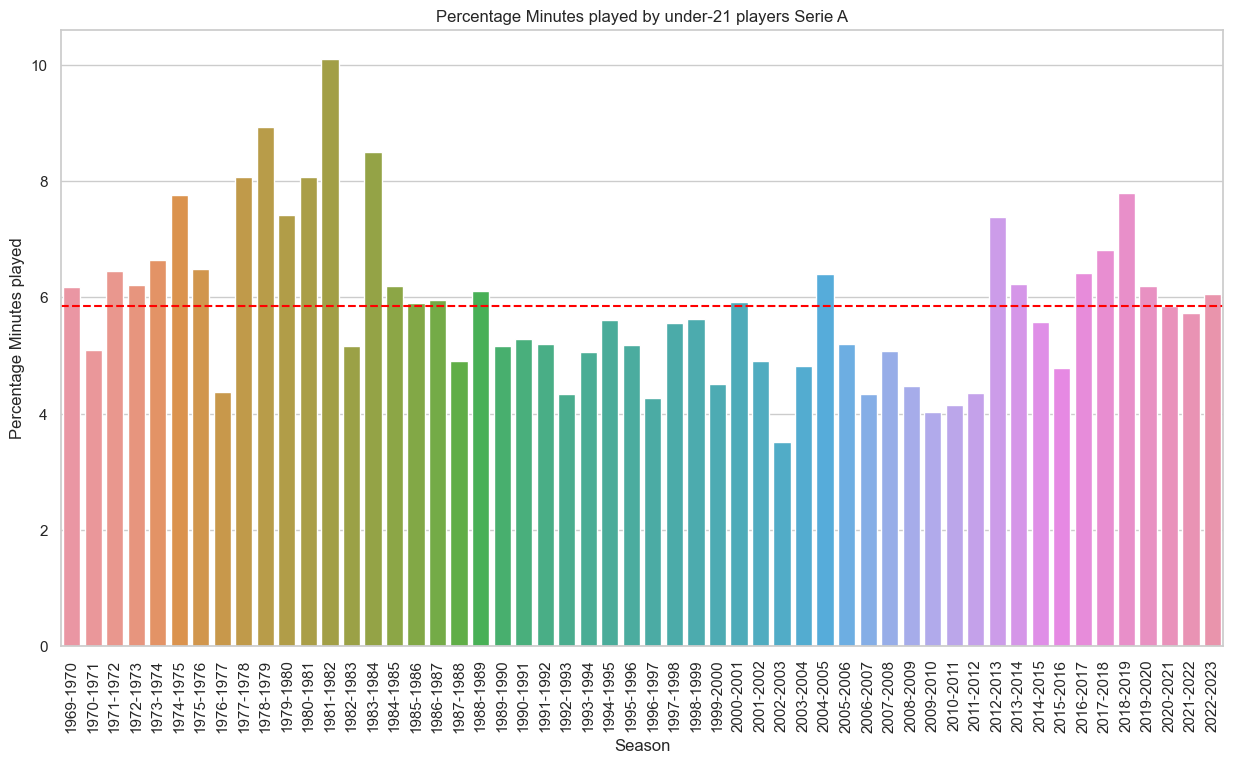

In [46]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.barplot(x=mins_played.index, y=mins_played["Minuti giocati under21"])
plt.xticks(rotation=90)
plt.xlabel("Season")
plt.ylabel("Percentage Minutes played")
plt.title("Percentage Minutes played by under-21 players Serie A")
#print line mean
plt.axhline(mins_played["Minuti giocati under21"].mean(), color='red', linestyle='--')






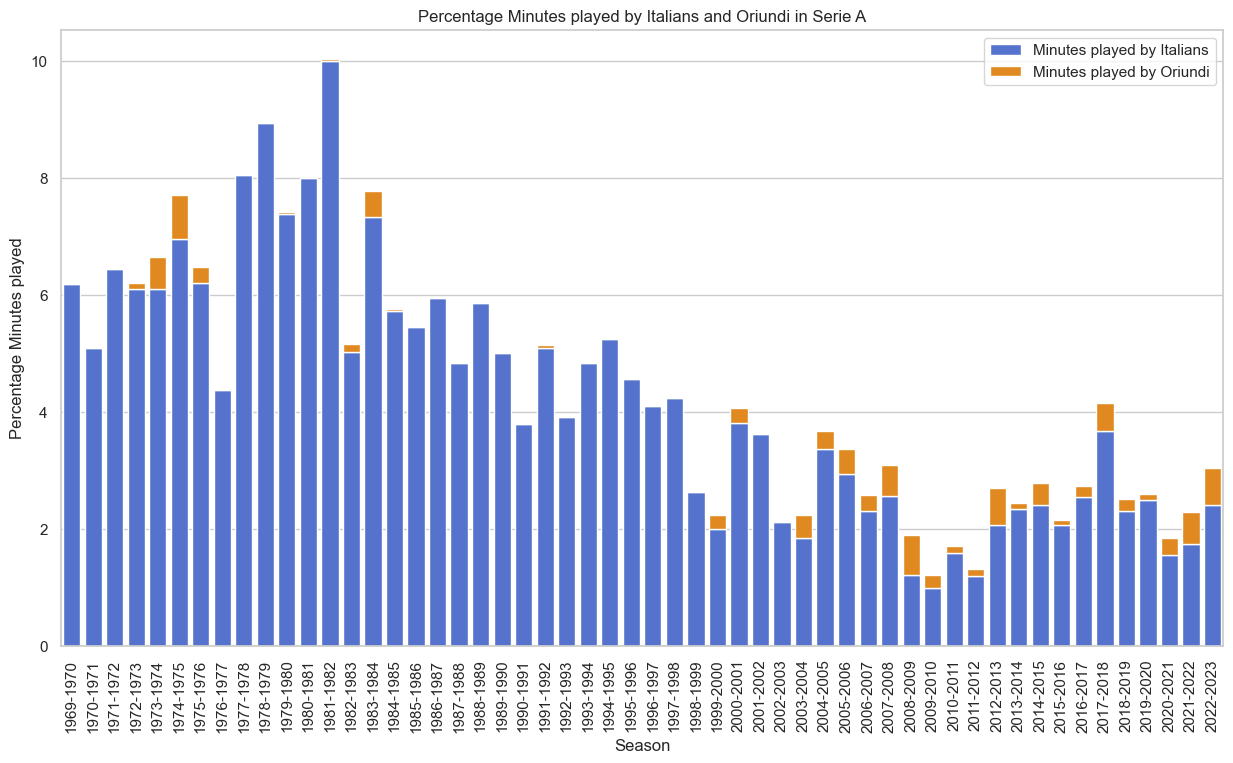

In [48]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Italiani", color="royalblue",label="Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Oriundi",color="darkorange",label="Minutes played by Oriundi", bottom=mins_played["Minuti giocati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians and Oriundi in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

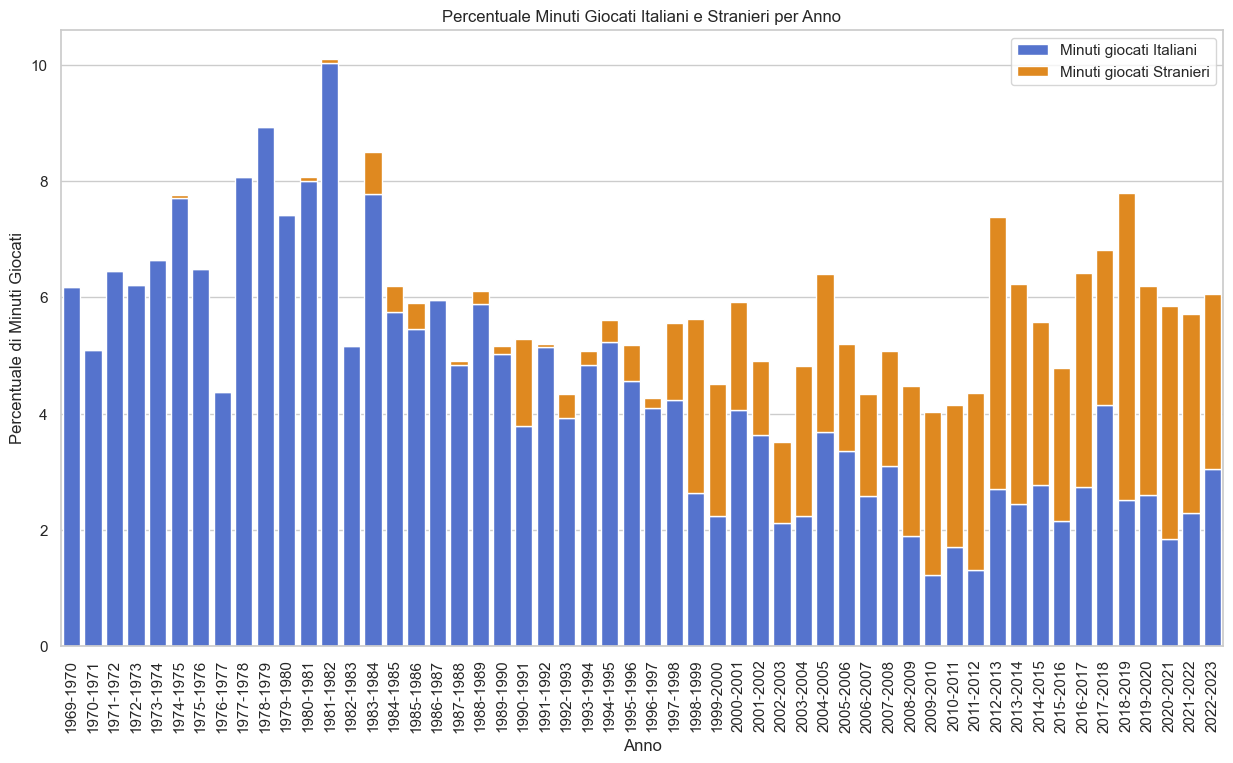

In [ ]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Italiani", color="royalblue",label="Minuti giocati Italiani")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Stranieri",color="darkorange",label="Minuti giocati Stranieri", bottom=mins_played["Minuti giocati normalizzati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Anno')
plt.ylabel('Percentuale di Minuti Giocati')
plt.title('Percentuale Minuti Giocati Italiani e Stranieri per Anno')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

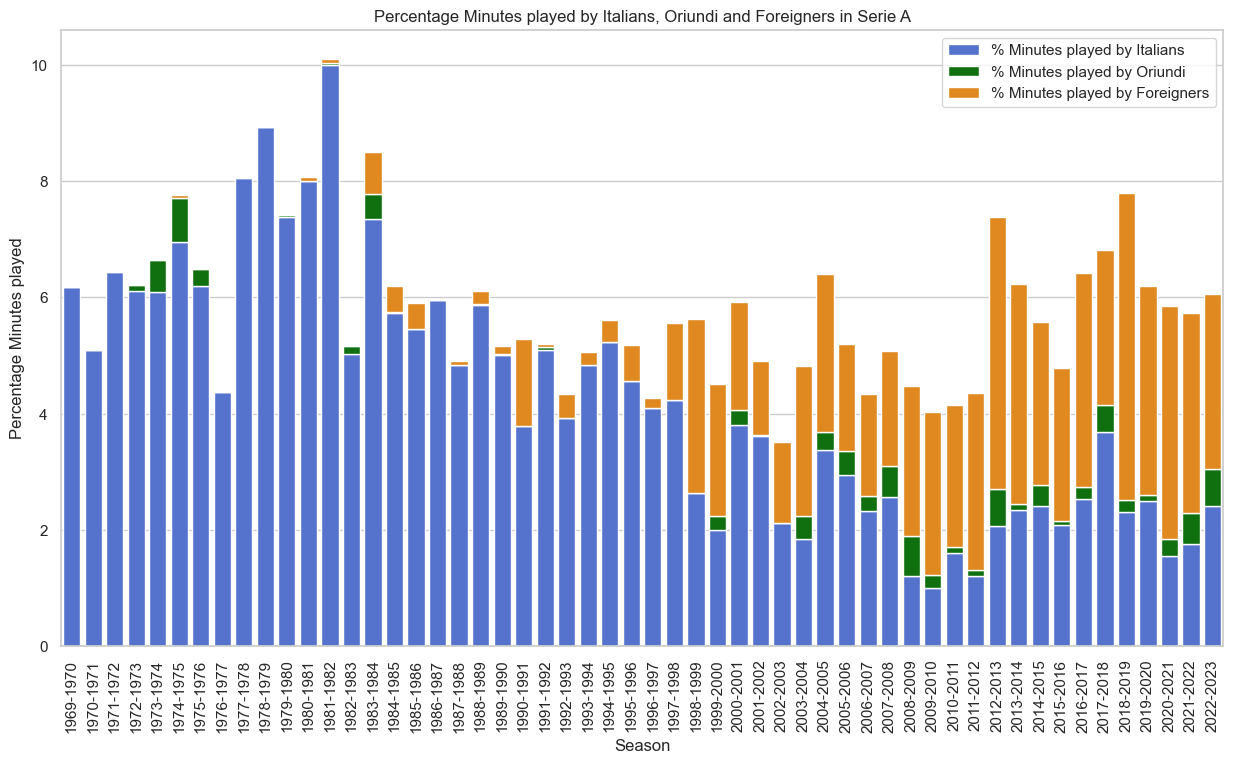

In [49]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Italiani", color="royalblue",label="% Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Oriundi",color="green",label="% Minutes played by Oriundi", bottom=mins_played["Minuti giocati Italiani"])
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Stranieri",color="darkorange",label="% Minutes played by Foreigners", bottom=mins_played["Minuti giocati Italiani"] + mins_played["Minuti giocati Oriundi"])



# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians, Oriundi and Foreigners in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

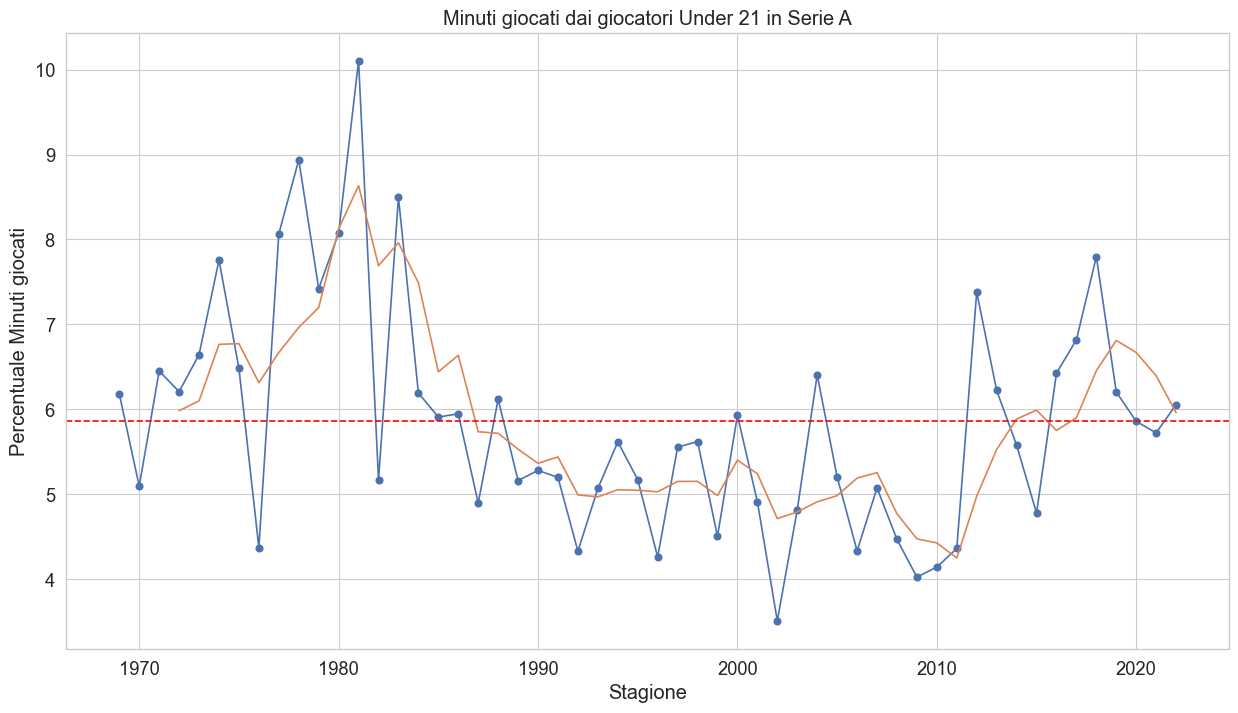

In [166]:
#print a line plot with the minutes played normalized with line mean and marker 
plt.figure(figsize=(15,8))
plt.plot(mins_played.index,mins_played["Minuti giocati under21"],marker='o')
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A")
#print line mean
mins_played["Minuti giocati under21"].rolling(4).mean().plot()
plt.axhline(mins_played["Minuti giocati under21"].mean(), color='red', linestyle='--')
